In [90]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 
import os  

def is_even(num) -> bool: 
    return num % 2 == 0 

def is_odd(num) -> bool: 
    return num % 2 != 0 

In [ ]:

def i_file_read(path: str): 
    with open(path, 'rb') as f:
        data = np.fromfile(f, dtype=np.int16).astype(np.float32) 

    I = data[0::2]
    Q = data[1::2]

    return I, Q

print(os.getcwd())

I, Q = i_file_read('./qpsk_signal_no_phase.bin') 

print(I)
print(Q)

d:\Home\Documents\GitHub\sdr-dsp-playground
[ 121. -428.  199. ...  -54. -207.  180.]
[-337.  -43. -184. ...  271.  323.  323.]


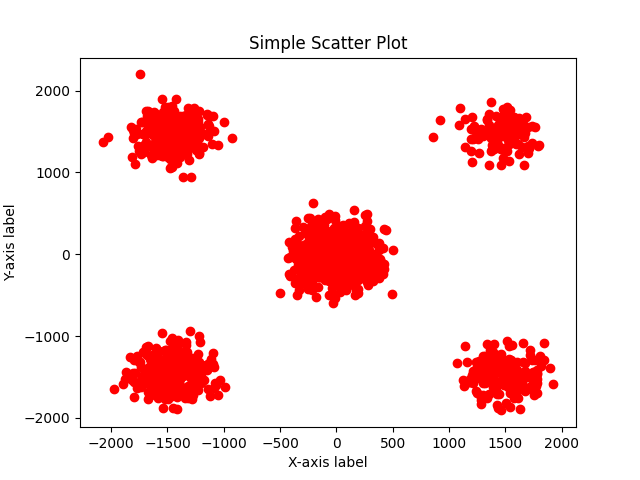

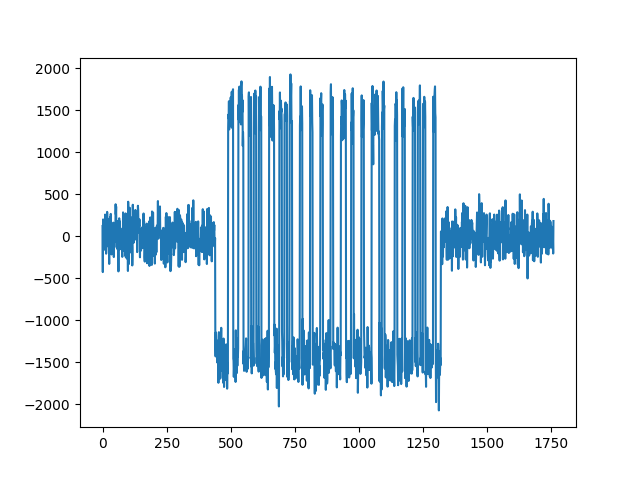

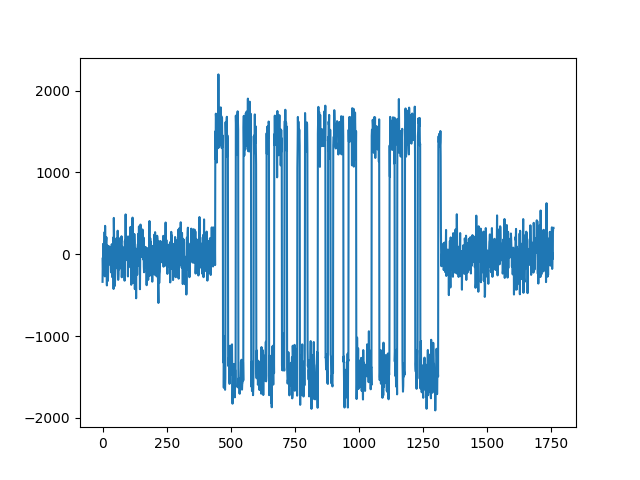

In [92]:
def i_q_visio(): 
    fig, ax = plt.subplots()

    ax.scatter(I, Q, label='Scatter plot', color='red')

    ax.set_xlabel('X-axis label')
    ax.set_ylabel('Y-axis label')
    ax.set_title('Simple Scatter Plot')

    fig1, ax = plt.subplots()

    #ax.plot(I, Q, label='Scatter plot', color='red')
    ax.plot(I)

    # ax.set_xlabel('X-axis label')
    # ax.set_ylabel('Y-axis label')
    # ax.set_title('Simple Scatter Plot')
    # ax.legend()

    fig2, ax2 = plt.subplots()

    #ax.plot(I, Q, label='Scatter plot', color='red')
    ax2.plot(Q)

    # ax2.set_xlabel('X-axis label')
    # ax2.set_ylabel('Y-axis label')
    # ax2.set_title('Simple Scatter Plot')
    # ax2.legend()
i_q_visio()



This is a display math example:
$$
\int_0^\infty e^{-x^2} dx = \frac{\sqrt{\pi}}{2}
$$

$$
T_{symb}
$$


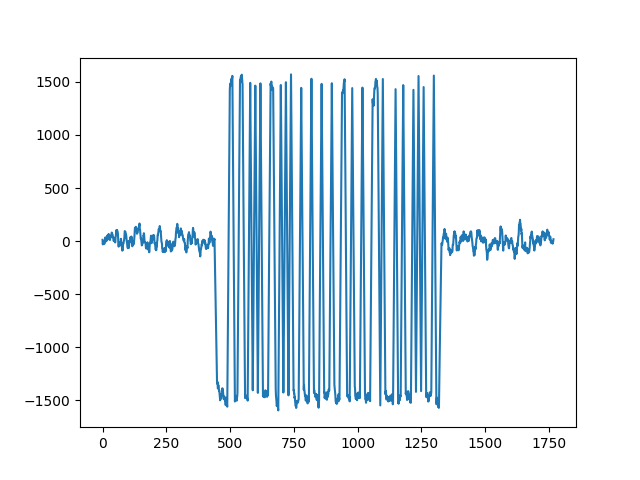

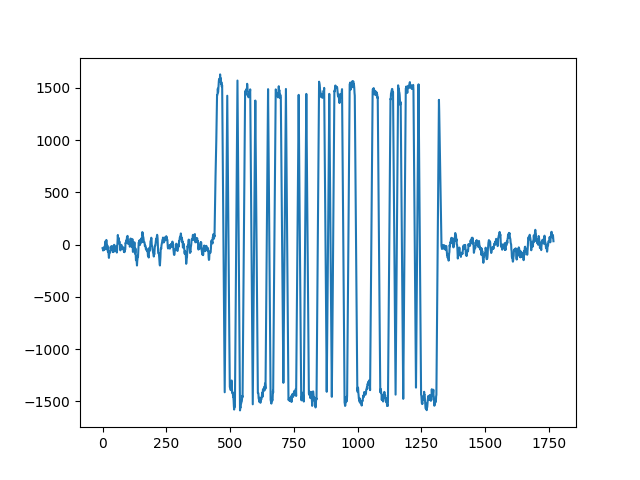

In [93]:
tau_symb = 10   
def match_filter():   
    ones = np.ones(tau_symb) / tau_symb 

    I_convd = np.convolve(I, ones, mode="full") 
    Q_convd = np.convolve(Q, ones, mode="full") 
    
    fig_i, ax = plt.subplots() 

    ax.plot(I_convd) 

    fig_q, ax = plt.subplots() 

    ax.plot(Q_convd)
    
    return I_convd, Q_convd 

I, Q = match_filter()
    

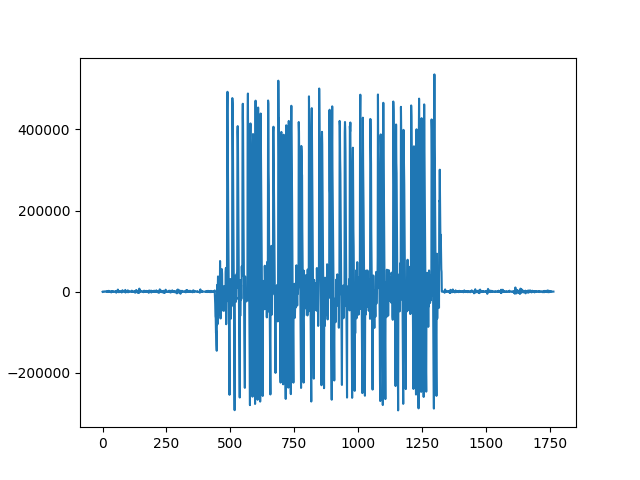

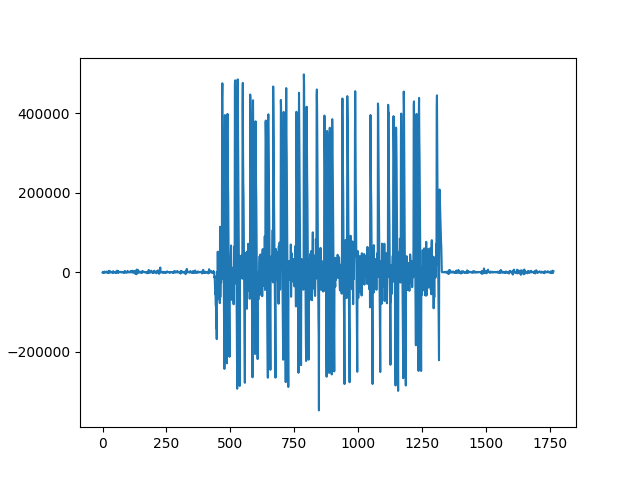

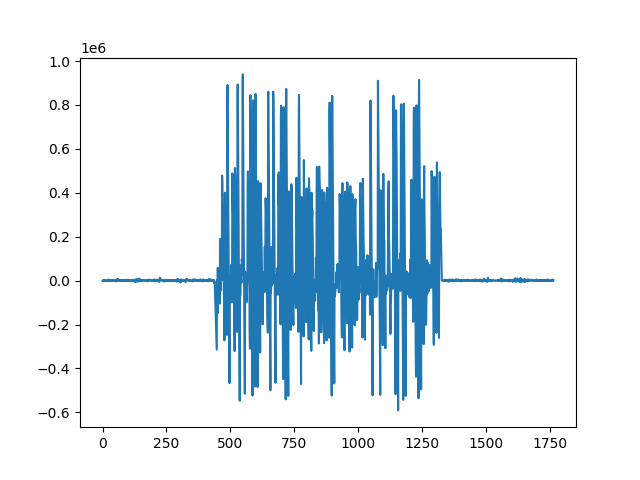

In [94]:
def gardner_timing_error_qpsk(I, Q):
    errors_i = []
    errors_q = []
    for n in range(1, len(I) - 2):
        I_n, I_n_half, I_n_minus_T = I[n], I[n - 1], I[n + 1]
        Q_n, Q_n_half, Q_n_minus_T = Q[n], Q[n - 1], Q[n + 1]

        # Ошибка Гарднера
        error_I = I_n_half * (I_n - I_n_minus_T)
        error_Q = Q_n_half * (Q_n - Q_n_minus_T)
        errors_i.append(error_I) 
        errors_q.append(error_Q) 

    return np.array(errors_i), np.array(errors_q)

Ierr, Qerr = gardner_timing_error_qpsk(I, Q)

fig3, ax = plt.subplots()
ax.plot(Ierr)

fig3, ax = plt.subplots()
ax.plot(Qerr)

IQ_err = Ierr + Qerr 

fig4, ax = plt.subplots() 
ax.plot(IQ_err)

[s1,s2,s3,s4] * [0,1,0] 
  |  
[0, s2, 0]
    |
    [0, s3, 0]

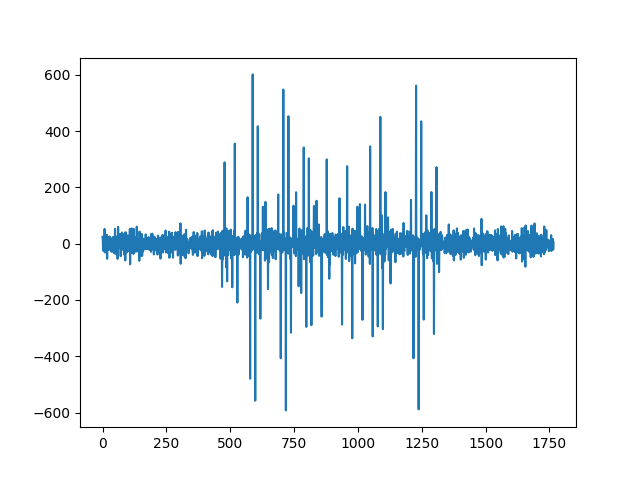

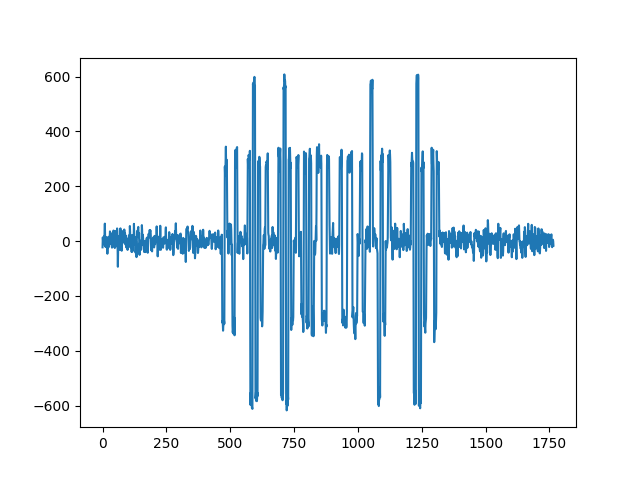

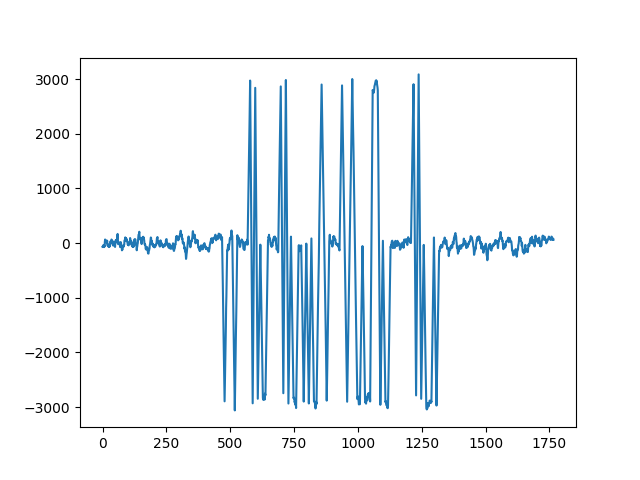

In [95]:
x0 = np.convolve(I+Q, [0.5, -1, 0.5], mode="valid");  #

fig, ax = plt.subplots() 

ax.plot(x0) 

x1 = np.convolve(I+Q, [0.5, 0, -0.5], mode="valid") 

fig, ax = plt.subplots() 

ax.plot(x1) 

x3 = np.convolve(I+Q, [0,1,0], mode="valid") 

fig, ax = plt.subplots() 

ax.plot(x3) 


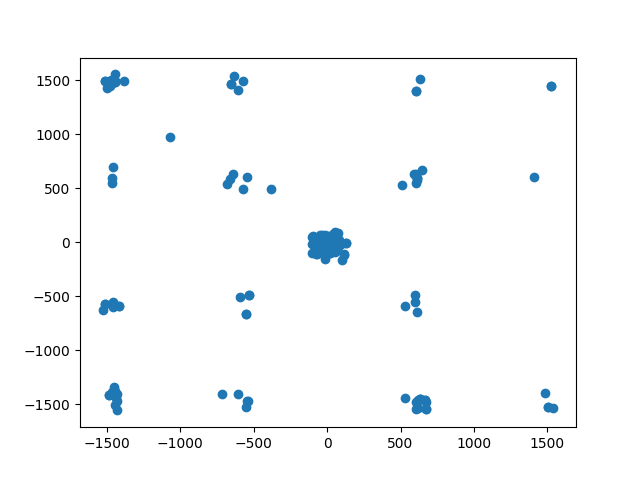

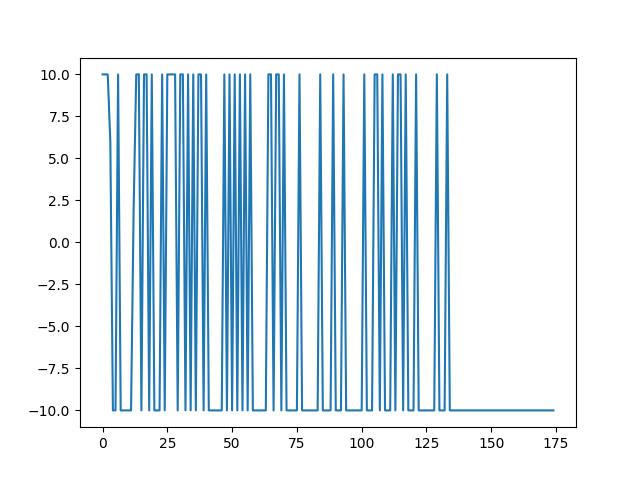

In [ ]:
def timing_sync(Nsps=10, N1st=2):
    damp = np.sqrt(2) / 2   

    # Полоса?? ЧЕГО БЛЯТЬ ЗА ПОЛОСА НАХУЙ
    damping_factor = 2.7
    band = (0.5 * np.pi / 500) / (damp + 1 / (4 * damp)) 
    mi1 = (4 * damp * band) / ((1 + 2 * damp * band + band ** 2) * damping_factor)
    mi2 = (4 * band ** 2 ) / ((1 + 2 * damp * band + band ** 2) * damping_factor)

    if (Nsps > 2): 
        # TODO docs
        ns, err, offset = [N1st], [], []
        # TODO docs
        offs, adapt1, adapt2 = 0,0,0 
        # TODO docs 
        
        Is = [] 
        Qs = []

        for n in range(N1st, len(I) -  2 * Nsps, Nsps): 
            #gardner
            err_I = (I[n + Nsps + offs] - I[n + offs]) * I[n + Nsps // 2 + offs]
            err_Q = (Q[n + Nsps + offs] - Q[n + offs]) * Q[n + Nsps // 2 + offs]

            cur_err = -(err_I + err_Q) 

            adapt2 += mi2 * cur_err
            adapt1 += adapt2 + mi1 * cur_err

            # нормализация
            adapt1 = np.clip(adapt1, -1, 1) 

            offs = round(adapt1 * Nsps)     
            offset.append(offs) 
            err.append(cur_err) 
            ns.append(n + Nsps + offs) 
        
        Is = I[ns] 
        Qs = Q[ns] 

    return np.array(ns), np.array(Is), np.array(Qs), np.array(err), np.array(offset)


ns, Is, Qs, err, offset = timing_sync() 

fig, ax = plt.subplots() 

ax.scatter(Is, Qs)

fig, ax = plt.subplots() 

ax.plot(offset) 
# def qpsk_sync():
#     tau = 1.0 
#     step = 0.01
#     I_sync, Q_sync = [], [] 

#     for n in range(1, len(I) - 2): 
#         tau += step * IQ_err[n] 

#         idx = abs(int(round(tau))) 

#         if idx < len(IQ_err): 
#             I_sync.append(I[idx]) 
#             Q_sync.append(Q[idx]) 

#     return I_sync, Q_sync

# I_synced, Q_synced = qpsk_sync()

# fig, ax = plt.subplots() 

# ax.scatter(I_synced, Q_synced)

In [97]:
def qpsk_modulate(v_bits): 
    S = np.array(); 
    for i in range(len(v_bits)):
        bit = v_bits[i] 

        if (bit == 0): 
            bit = -1
        else: 
            bit = 1 

        if (is_even(i)): # I 
            S.append(bit * np.cos() )
        #if (is_odd(i)):  # Q 
